# DAT550 Final Project

## Music to note transcriptor
________________


## Used Dataset

The dataset contained in the repository in Data/In/classical

- https://www.kaggle.com/soumikrakshit/classical-music-midi


## Other Tools
### FluidSynth (for synthesizing the MIDI files)
https://github.com/FluidSynth/fluidsynth/releases
### Lilypond (for generation of the final music notation)
https://lilypond.org/

### Python libraries

In [ ]:
%pip install pretty_midi
%pip install mido
%pip install midi2audio
%pip install tqdm
%pip install --upgrade tensorflow
%pip install librosa
%pip install jupyter_contrib_nbextensions && jupyter contrib nbextension install
%pip install music21


## Run ModelCreation for the preprocessing and training pipeline (takes time...)

In [1]:
import ModelCreation
# ModelCreation.main()

## Load data from pickle file

In [3]:
from Utils import Pickle
feature_fp = r'Data/Out/Pickle/features_1D.pkl' # use features_2D for Image data of CNN
label_fp = r'Data/Out/Pickle/labels.pkl'

features = Pickle.load_pickle(feature_fp)
labels = Pickle.load_pickle(label_fp)

Loading pickle file from Data/Out/Pickle/features_1D.pkl
Loading pickle file from Data/Out/Pickle/labels.pkl


## Data structure

Feature lists are stored in a dictionary. Each list has equal length:

In [4]:
features.keys()

dict_keys(['mel', 'mfcc', 'cqt'])

In [5]:
len(features['mel']), len(features['mfcc']), len(features['cqt'])

(64659, 64659, 64659)

Each list element is the spectrogram of a chunk of music of length 1/16s (=62,5ms). The first dimension in a spectrogram is the number of frequency bands, i.e. features and the second dimension is time.

In [6]:
features['mel'][0].shape

(200, 4)

The labels correspond to the keys played at each chunk with the same list index. Since a standard piano keyboard has 88 keys, each label is a vector with 88 entries:

In [7]:
len(labels), labels[0].shape

(64659, (88,))

0 means the key at the index is not played, 1 means it is played. E.g. in the 100th chunk five keys are played:

In [8]:
labels[100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Exploratory data analysis

After synthesizing the wave files and preparing the training data, we look at some properties of the data:

### Analysing the labels

Overall, the labels are rather sparse vectors:

In [9]:
num_keys = len(list(filter(lambda x: x > 0, labels.flatten())))
total = len(labels)*labels[0].shape[0]
print('Number of times a key is played:' , num_keys)
print('Total number of key labels:', total)

Number of times a key is played: 129240
Total number of key labels: 5689992


Hence, each key is played on average only 129326/5689992 = 2.23 % of the time.

The following plot shows the relative frequencies of each key over the whole dataset. We can see that the keys in the middle of the keyboard are played most frequently:

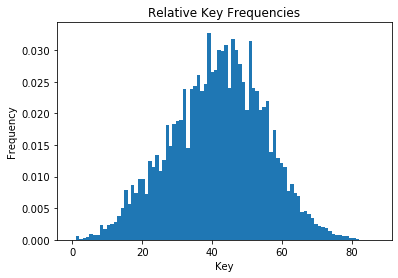

In [10]:
from Utils import Evaluation
Evaluation.plot_label_hist(labels)

### Spectrogram analysis

In [13]:
import librosa
from matplotlib import pyplot as plt
SAMPLE_RATE = 16000

To process the music, we use spectral representations that show the intensity of certain frequencies at each point in time. The representations are mel-scaled spectrograms, Mel-frequency cepstral coefficients (MFCCs), and Constant-Q power spectrums. The intensity was scaled in decibels (dB) and then normalised.

Mel-scaled spectrogram

[Text(0.5, 1.0, 'Normalized mel-scaled spectrogram')]

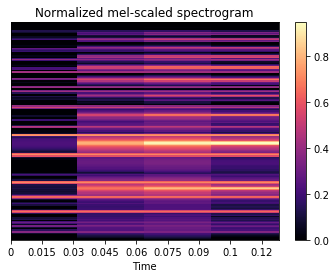

In [14]:
fig, ax = plt.subplots()
img = librosa.display.specshow(features['mel'][100], x_axis='time', sr=SAMPLE_RATE, ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='Normalized mel-scaled spectrogram')

Mel-frequency cepstral coefficients (MFCCs)

[Text(0.5, 1.0, 'Normalized MFCC')]

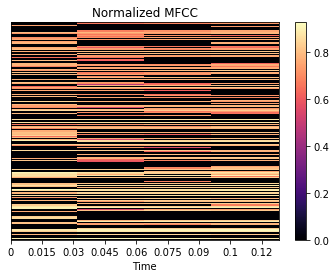

In [15]:
fig, ax = plt.subplots()
img = librosa.display.specshow(features['mfcc'][100], x_axis='time', sr=SAMPLE_RATE, ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='Normalized MFCC')

constant-Q transform

[Text(0.5, 1.0, 'Normalized Constant-Q power spectrum')]

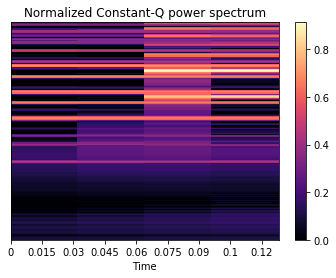

In [16]:
fig, ax = plt.subplots()
img = librosa.display.specshow(features['cqt'][100], x_axis='time', sr=SAMPLE_RATE, ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='Normalized Constant-Q power spectrum')

### PCA

Now, we will look at the dimensionality of the data:

In [17]:
import numpy as np
def num_comp_for_variance(explained_var, variances=[0.9, 0.95, 0.99, 0.999]):
    for var in variances:
        for i, j in enumerate(np.cumsum(explained_var)):
            if j>=var:
                print(i+1, 'components for', '%.2f'%(j*100), 'percent of the variance')
                break

Mel Spectrogram

In [54]:
from sklearn.decomposition import PCA
pca = PCA(n_components=800) 
melspec_input_features = [spec.flatten() for spec in features['mel']]
pca_ms = pca.fit_transform(melspec_input_features)
ms_explained_var = pca.explained_variance_ratio_
num_comp_for_variance(ms_explained_var)

49 components for 90.08 percent of the variance
99 components for 95.03 percent of the variance
295 components for 99.00 percent of the variance
599 components for 99.90 percent of the variance


MFCC

In [55]:
pca = PCA(n_components=800) 
mfcc_input_features = [spec.flatten() for spec in features['mfcc']]
pca_mfcc = pca.fit_transform(mfcc_input_features)
mfcc_explained_var = pca.explained_variance_ratio_
num_comp_for_variance(mfcc_explained_var)

388 components for 90.03 percent of the variance
536 components for 95.01 percent of the variance
717 components for 99.01 percent of the variance
780 components for 99.90 percent of the variance


CQT

In [56]:
pca = PCA(n_components=800) 
cqt_input_features = [spec.flatten() for spec in features['cqt']]
pca_cqt = pca.fit_transform(cqt_input_features)
cqt_explained_var = pca.explained_variance_ratio_
num_comp_for_variance(cqt_explained_var)

56 components for 90.05 percent of the variance
120 components for 95.02 percent of the variance
356 components for 99.00 percent of the variance
621 components for 99.90 percent of the variance


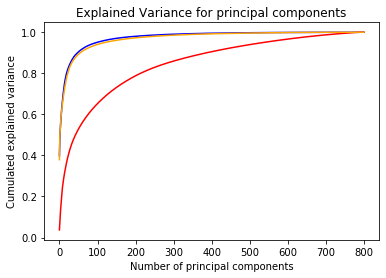

In [57]:
plt.plot(np.cumsum(ms_explained_var), color="blue")
plt.plot(np.cumsum(mfcc_explained_var), color="red")
plt.plot(np.cumsum(cqt_explained_var), color="orange")
plt.xlabel('Number of principal components')
plt.ylabel('Cumulated explained variance')
plt.title('Explained Variance for principal components')
plt.show()

On the first sight, we see that the first n principal components of the spectrogram data of the constant-q transform retain less variance than the first n principal components of the mel-scaled spectrograms and mfccs, which have almost equal variances. 
The dimensionality is not decreased drastically while retaining almost all of the variance in any of the feature datasets, at most 25% dimensionality reduction for the mel-scaled spectrograms while retaining 99.9% of the variance.
As the timing information is also lost in the process, we do not use PCA as preprocessing before training the neural networks.

### TSNE

In [64]:
from sklearn.manifold import TSNE

# reduce to 100 dimensions first by PCA to speed up computation
tsne_ms = TSNE(n_components=2).fit_transform(PCA(n_components=100).fit_transform([spec.flatten() for spec in features['mel']]))
tsne_mfcc = TSNE(n_components=2).fit_transform(PCA(n_components=100).fit_transform([spec.flatten() for spec in features['mfcc']]))
tsne_cqt = TSNE(n_components=2).fit_transform(PCA(n_components=100).fit_transform([spec.flatten() for spec in features['cqt']]))

tsne_ms.shape, tsne_mfcc.shape, tsne_cqt.shape

((64659, 2), (64659, 2), (64659, 2))

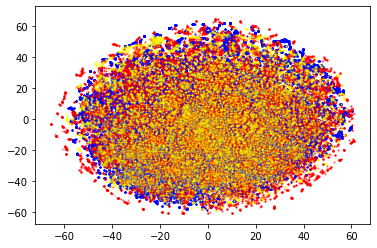

In [83]:
plt.scatter(tsne_ms.T[0], tsne_ms.T[1], color="blue",alpha=1, s=1)
plt.scatter(tsne_mfcc.T[0], tsne_mfcc.T[1], color="red",alpha=0.2, s=1)
plt.scatter(tsne_cqt.T[0], tsne_cqt.T[1], color="yellow",alpha=0.1, s=1)

TSNE for mel spectrograms

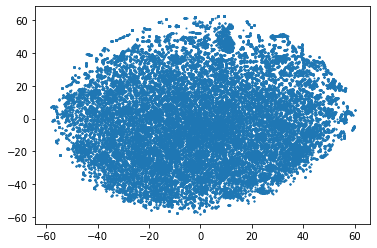

In [78]:
plt.scatter(tsne_ms.T[0], tsne_ms.T[1], s=1)

TSNE for MFCCs

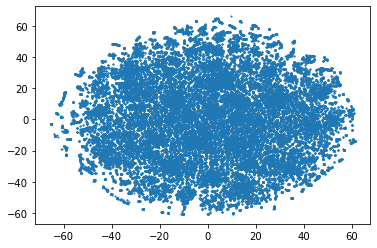

In [79]:
plt.scatter(tsne_mfcc.T[0], tsne_mfcc.T[1], s=1)

TSNE for CQT

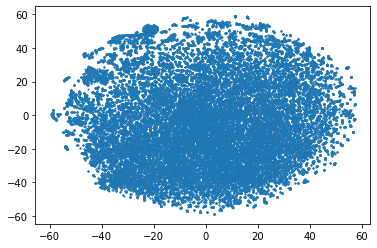

In [80]:
plt.scatter(tsne_cqt.T[0], tsne_cqt.T[1], s=1)

All TSNE visualisations have a similar scale and shape. Thus we can assume that all feature extraction methods preserve similarities among the spectrogram data in similar ways.

## Demonstration

For a detailed evaluation see the ModelsEvaluation.ipynb notebook. In the following we have a look at the actual generated music transcription. The image files appear in the report.
Therefore we take the following steps:
 - read a new unknown midi file
 - generate a transcription with music21 based on the original file
 - synthesize the midi file, run feature extraction
 - predict the notes based on the synthesized sound
 - generate a MIDI file from the predictions
 - generate a transcription with music21 based on the predicted file

## Original Music sheet
![Chopin](../img/chopin_prelude_a.png)

In [7]:
os.path.split(f'./{midi_file}.wav')[:-1]

('.',)

In [214]:
# feature extraction with default parameters
import sys
sys.path.append('../')
import os
import numpy as np
from Utils import Feature, Midi
midi_file = './Chopin__.mid'

import importlib
importlib.reload(Midi)
tempo = 1/8
midi_song = Midi.get_midi_file(midi_file,tempo=tempo)
Midi.midi2wave(midi_file,f'{midi_file}.wav',sound_font='../Soundfont/198_Yamaha_SY1_piano.sf2')
features_to_process = Feature.FEATURE_TYPES
MLP_MFCC_THRESHOLD = 0.052892983
features_1D = {x:[] for x in features_to_process }
feature = Feature.Feature(tempo,
                        midi_song,
                        f'./{midi_file}.wav',
                        features_to_process,
                        sample_rate = 16000,
                        max_freq=8500,
                        verbose=False)
y =[]
max_len = np.max([len(i) for i in feature.Midi_2_Audio_Time])
for index, timeframe in enumerate(feature.Midi_2_Audio_Time):
    y.append(feature.Midi_Notes[index])
    if len(timeframe) < max_len:
        t = timeframe.copy()
        for i in range(max_len-len(timeframe)):
            t.append(timeframe[-i])
            for f2p in features_to_process:
                features_1D[f2p].append(feature.Data[f2p][:,t])
    else:
        for f2p in features_to_process:
            features_1D[f2p].append(feature.Data[f2p][:,timeframe])
y = np.array(y)
X = np.array(features_1D[f2p])
X = np.array([x.flatten() for x in X])



In [215]:
# load model
import tensorflow as tf
import keras
from Utils import Misc, Evaluation
feature = 'mel'
model_path = Misc.get_dir('../Data','Out','Model')
model = Evaluation.load_models(model_path,['CNN2D_V3'],[feature])[f'CNN2D_V3_{feature}']

model.compile(loss=keras.losses.binary_crossentropy,
            optimizer=keras.optimizers.Adam(),
            metrics=['accuracy'])

loading model CNN2D_V3_mel.h5...


In [216]:
import importlib
importlib.reload(Misc)
features_2D=dict()
for f2p in features_to_process:
    data = np.array(features_1D[f2p])
    features_2D[f2p] =  np.array(
    [ Misc.vec2img(x,fmax=8500,sr=16000,scale=4,img_type=f2p) for x in data ] )
features_2D = {x[0]:np.array( x[1], dtype = 'float64')/255 for x in features_2D.items() }

In [218]:
X = features_2D[feature]
# predict
predict = None
with tf.device('/device:CPU:0'):
    X = tf.convert_to_tensor(X)
    predict = model.predict(X)
predict = np.array(predict)

In [209]:
predict[13][20:]
p = np.array(predict)
p = [predict[n]//predict[n][np.argmax(p[n])] for n in range(len(predict))]

In [219]:
th = 1e-1
p = np.array(predict)
for i in range(predict.shape[0]):
    for j in range(predict.shape[1]):
        p[i][j] = 0  if predict[i][j] < th else 1

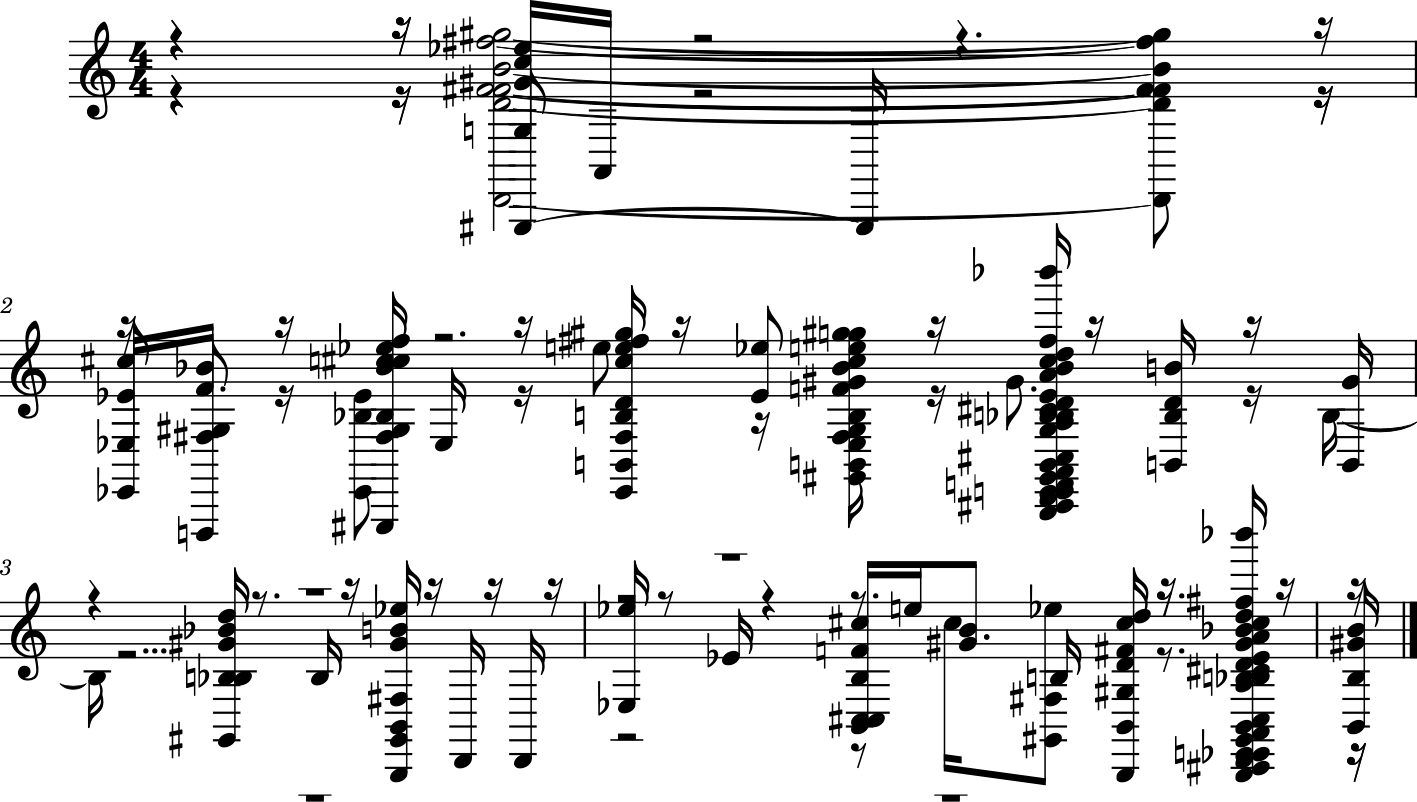

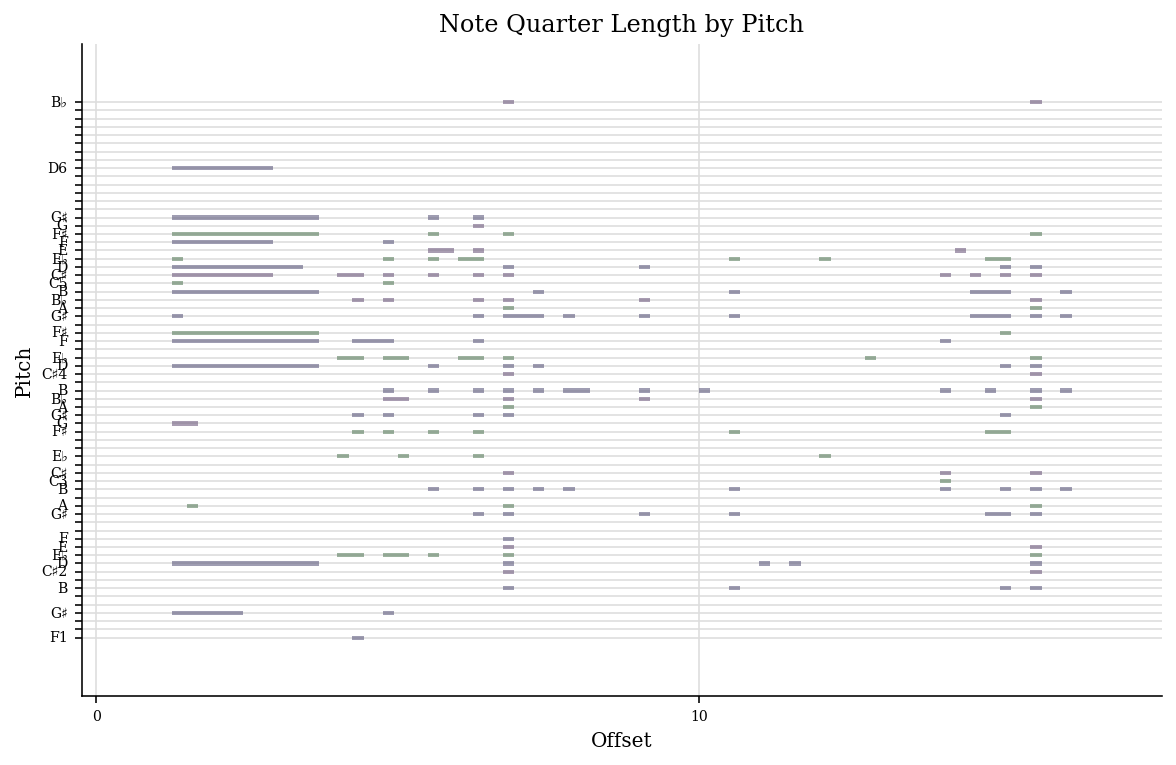

In [220]:

midi_time= 1/8

predicted_midi_vec = np.array(p, dtype=int)
# recreate MIDI
from Utils import Midi
midi_vec = [(midi_time,x) for x in predicted_midi_vec]
predicted_midi = Midi.vec_to_mid(midi_vec)
#Create new midi file
from mido import Message, MidiFile, MidiTrack
mid = MidiFile()
track = MidiTrack()
mid.tracks.append(track)
[track.append(m) for m in predicted_midi]
predicted_file = f'predicted_{fp}'
mid.save(predicted_file)

from music21 import midi
from music21 import environment 
us = environment.UserSettings()
us['musicxmlPath']='C:/Program Files/MuseScore 3/bin/MuseScore3.exe'
us['musescoreDirectPNGPath'] = 'C:/Program Files/MuseScore 3/bin/MuseScore3.exe'


mf = midi.MidiFile()
mf.open(predicted_file) # path='abc.midi'
mf.read()
mf.close()
s = midi.translate.midiFileToStream(mf)
s.show('midi')
s.plot()
s.show()

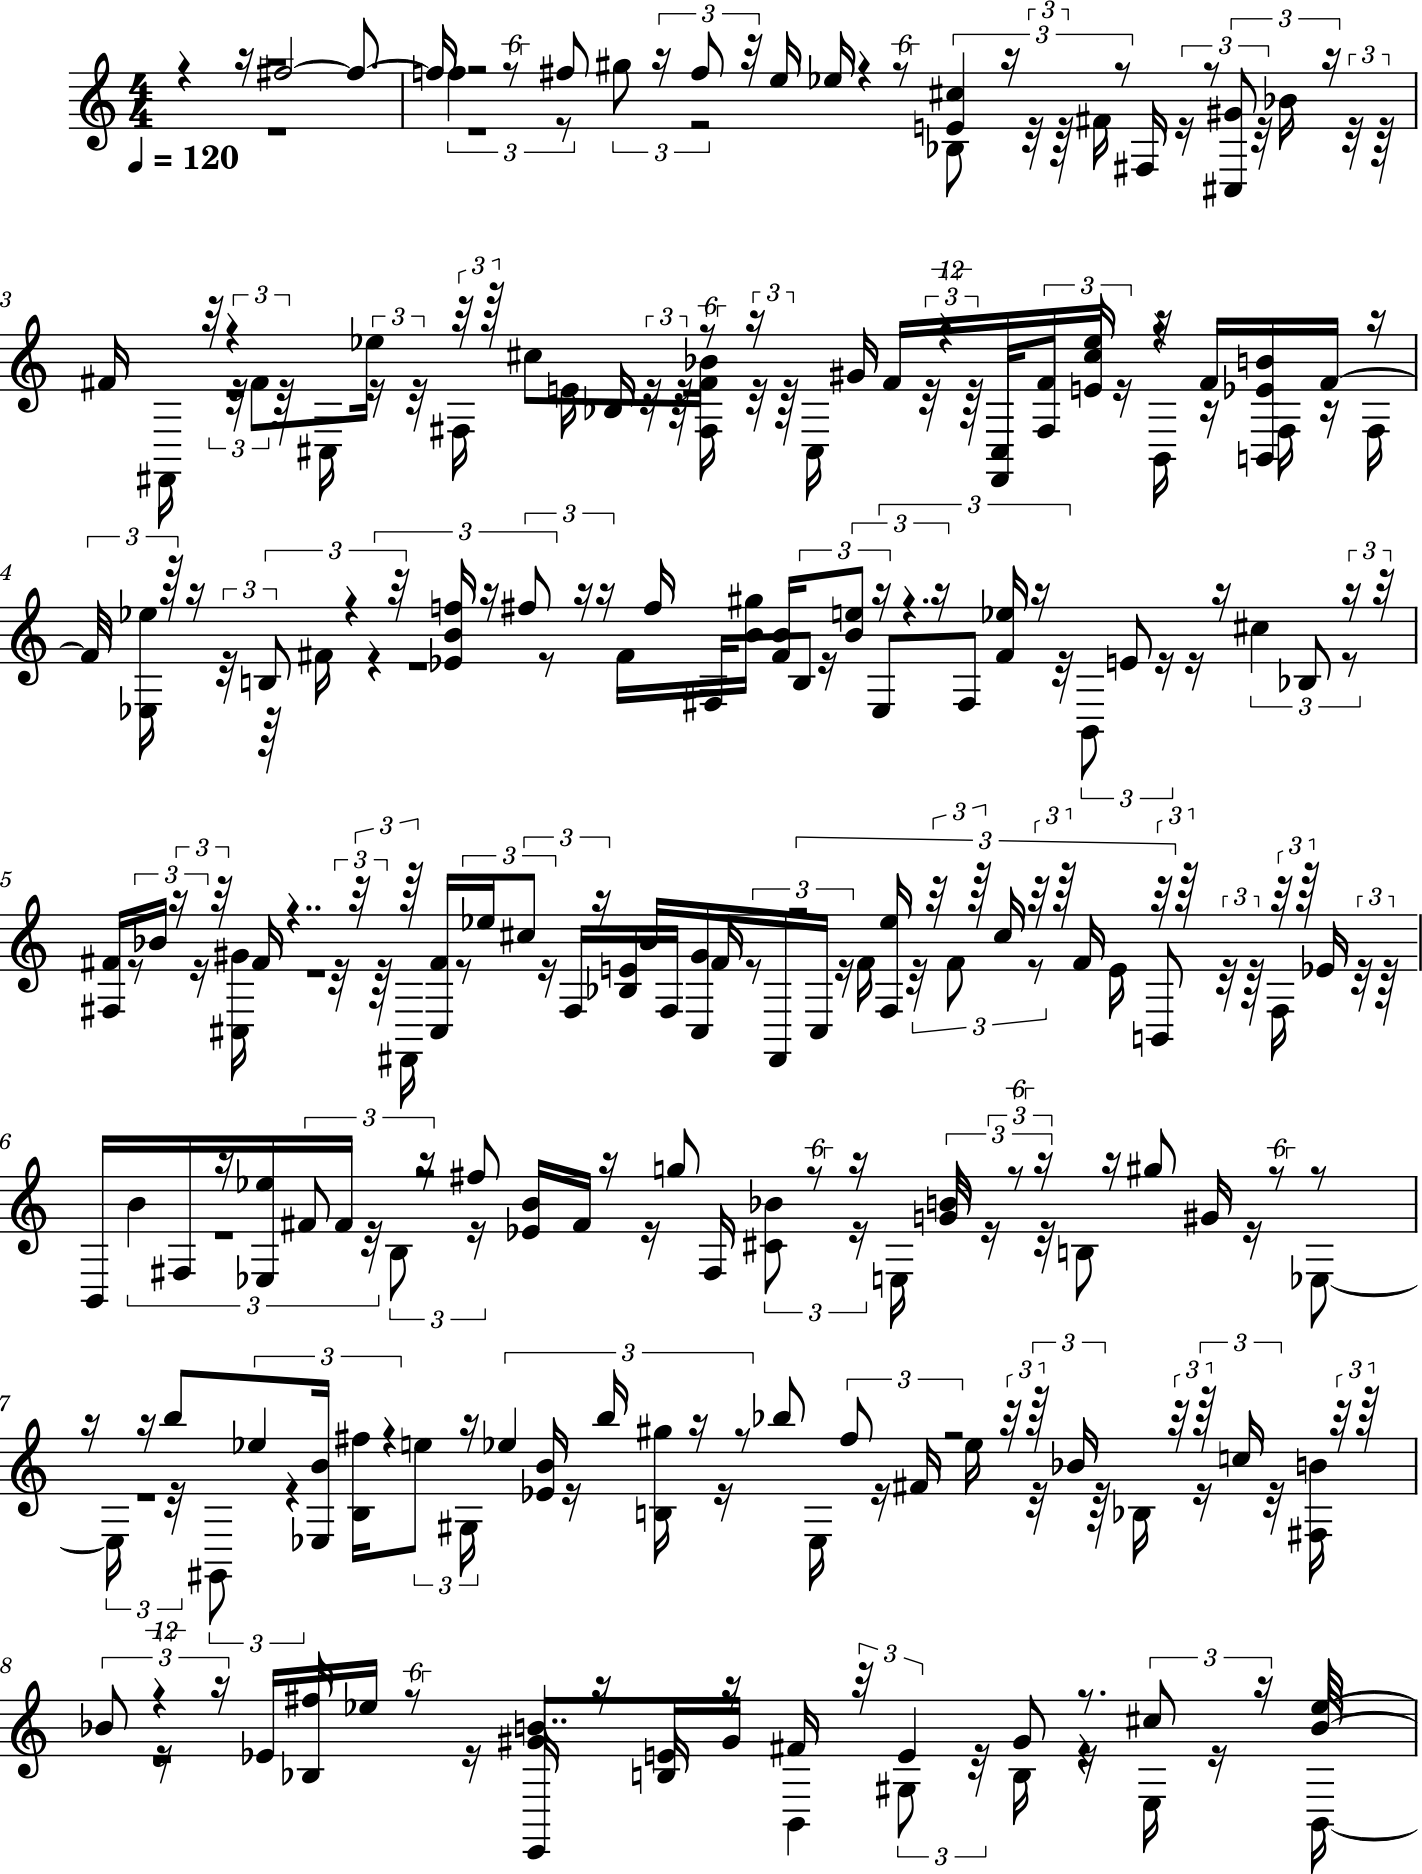

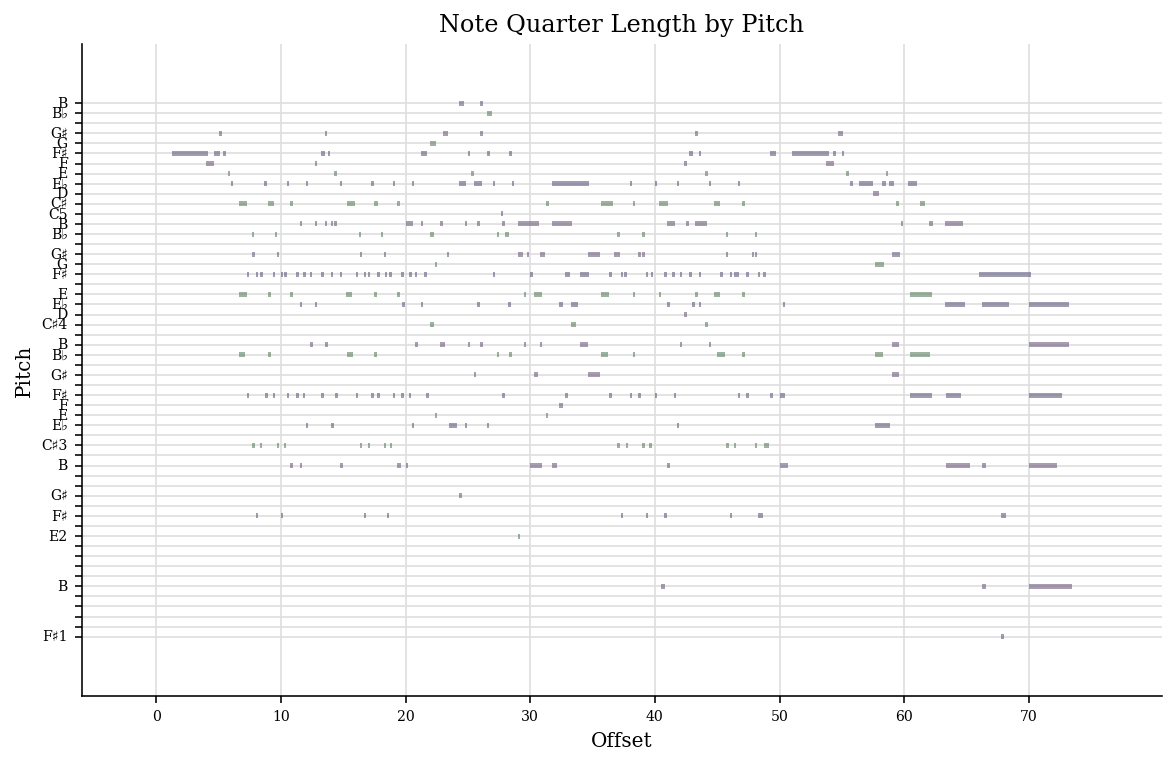

In [213]:
mf = midi.MidiFile()
mf.open(midi_file)
mf.read()
mf.close()
s = midi.translate.midiFileToStream(mf)
s.show('midi')
s.plot()
s.show()